# ECE 364 Lecture 9
## Automatic Differentiation III: PyTorch Autograd and Function Approximation

## Lecture goals
After this lecture, you should be able to:

* Explain how an objective function, e.g. loss or cost function, can be used to seed backpropagation
* Build computational graphs for estimating parameters for simple optimization problems.
* Combine PyTorch Autograd and gradient descent to perform function approximation using a toy dataset

## Recap of previous lectures
Earlier in our automatic differentiation lectures, we reviewed the usefulness of computing gradients for optimization problems, i.e. locating minima or maxima in a function of interest. Sometimes, an elegant closed-form solution is available to us by setting the gradient to zero and no elaborate computation is necessary to obtain the solution. However, almost always with more complicated functions and data, an immediate solution is intractable and instead we turn to iterative optimization methods like gradient descent. Intuitively, gradient descent seeks to successively reduce the magnitude of the gradient as we minimize the function of interest. The gradient points in the direct of steepest ascent; thus, gradient descent iteratively leads us down the negative gradient towards lower function values. Note that a corresponding gradient ascent algorithm may be similarly deployed for maximization problems.

Last lecture, introduced backpropagation as a computationally efficient and exact method for computing gradients in a computational graph representing some function. A forward pass through the graph generates values at each node, while a backward pass uses these values and the simple gradient rules at each node to compute partial derivatives through the computational graph. At larger scales, backpropagation is tedious (but possible!) to compute by hand as simple gradients are accumulated via chain rule.

In this lecture, we will combine our knowledge from the previous two lectures as well as the PyTorch Autograd engine to pose an optimization problem, automatically perform backpropagation, and apply gradient descent to complete our first learning problems of the semester! Before we continue, we will establish some basic notation that will be helpful throughout the course and connect optimization problems to our understanding of backpropagation.

## Optimization Problems and Objective Functions
The simplest version of an optimization problem may be stated as follows:
$$
\underset{x}{\min}f(x).
$$
The above expression gives an unconstrained optimization problem, i.e. no constraints on values $x$ can attain, where we look to find $x$ that minimizes the given **objective function** $f(x)$. An example of such an optimization problem could be
$$
\underset{x}{\min}~x^4-2x^3+3x^2-4x+5.
$$
We could of course pose optimization problems that involve maximization or even constraints on the variables for which we are optimizing. Some variations will be considered later in this course while many others are best left to ECE 490 (Introduction to Optimization). For now, we want to consider a basic problem setting, objective function, and how we may use backpropagation to our advantage.

Consider the problem of quadratic polynomial regression. We have some collection of input $x$ and output $y$ values that are taken from the unknown function where
$$
\begin{align*}
    f(x)&=ax^2+bx+c\\
    y_i &= f(x_i).
\end{align*}
$$
Note that we use the subscript of $i$ to indicate we may have several data points relating the inputs and outputs of the unknown function. Our goal is to regress the values of $a$, $b$, and $c$. We may accomplish by first posing a reasonable optimization problem. Suppose we refer to our dataset $\mathcal{D}=\{(x_i, y_i)\}_{i=1}^{N}$ as $N$ tuples of inputs and outputs. For a given guess of $a$, $b$, and $c$, the function will produce $f(x_i)$ while the correct or **ground-truth** value $y_i$ may be different. Thus, for current values of $(a, b, c)$, we have some amount of error. We need a reasonable objective function to minimize these errors with respect to this dataset. One highly popular choice is **mean squared error** (MSE). As the name suggests, we take the mean (average) of the sum of squared errors over the dataset. Let $\ell_{\textrm{mse}}(\mathcal{D})$ denote the MSE over the dataset.
$$
\ell_{\textrm{mse}}=\frac{1}{N}\sum_{i=1}^{N}(y_i-f(x_i))^2.
$$
The intuition for squaring the errors, $y_i-f(x_i)$, is that we want positive and negative errors to be treated the same. We now have all the elements of a well-posed optimization problem!
$$
\underset{a,~b,~c}{\min}~\frac{1}{N}\sum_{i=1}^{N}(y_i-f(x_i))^2
$$
Stated more exactly,
$$
\underset{a,~b,~c}{\min}~\frac{1}{N}\sum_{i=1}^{N}(y_i-(ax_i^2+bx_i+c))^2.
$$
For a single data point, the above objective function defines a computational graph. An input $x$ feeds into the graph of a quadratic function and the output of this graph is input to the MSE **loss function** that we seek to minimize. The result of the loss function is a scalar that we may use as the seed node for backpropagation throughout the graph! Consider the below depiction of this computational graph.

<div>
<center><img src="quadratic-regression-graph.png" width="1000"/> </center>
</div>

For just one data point, we can perform the forward pass to calculate values at each node, i.e. $ax^2$, $bx$, $\ell_{\textrm{mse}}(x_i, y_i)$. Then, we initiate backpropagation from the seed node to automatically compute the gradient of the loss function with respect to each parameter, i.e. $\frac{\partial \ell_{\textrm{mse}}}{\partial a}, \frac{\partial \ell_{\textrm{mse}}}{\partial b}, \frac{\partial \ell_{\textrm{mse}}}{\partial c}$. For completeness, we can easily derive these partial derivatives from the computational graph.

\begin{align*}
    \frac{\partial \ell_{\textrm{mse}}}{\partial w_7} &= 1 & \frac{\partial w_7}{\partial w_6} &= 2(w_6-w_5)\\
    \frac{\partial w_7}{\partial w_5} &= -2(w_6-w_5) & \frac{\partial w_5}{\partial w_4} &= 1\\
    \frac{\partial w_5}{\partial w_3} &= 1 & \frac{\partial w_5}{\partial c} &= 1\\
    \frac{\partial w_4}{\partial b} &=w_1 & \frac{\partial w_4}{\partial w_1} &=b\\
    \frac{\partial w_3}{\partial a} &=w_2 & \frac{\partial w_3}{\partial w_2} &=a\\
    \frac{\partial w_2}{\partial w_1} &=2w_1
\end{align*}

And finally, the adjoints:
\begin{align*}
    \bar{w}_7 &= \frac{\partial \ell_{\textrm{mse}}}{\partial w_7}\\
    \bar{w}_5 &= \bar{w}_7\frac{\partial w_7}{\partial w_5} = -2(w_6-w_5) &\bar{c} &= \bar{w}_5\frac{\partial w_5}{c} = -2(w_6-w_5)\\
    \bar{w}_4 &= \bar{w}_5\frac{\partial w_5}{\partial w_4} = -2(w_6-w_5) &\bar{w}_3 &= \bar{w}_5\frac{\partial w_5}{\partial w_3} = -2(w_6-w_5)\\
    \bar{b} &= \bar{w}_4\frac{\partial w_4}{\partial b} = -2w_1(w_6-w_5) &\bar{a} &= \bar{w}_3\frac{\partial w_3}{\partial a} = -2w_2(w_6-w_5)
\end{align*}

Note that we do not give $\bar{w}_6$, $\bar{w}_1$, and $\bar{w}_2$ since they are not necessary for this problem for deriving the partial derivatives with respect to $a$, $b$, and $c$. The above quantities give the result of backpropagation for one data point. However, we have a dataset of $N$ points, so how can we perform backpropagation across the whole dataset? We can just add the gradients due to each input-output pair! Differentiation is linear; thus, gradient of the entire objective with respect to $a$, $b$, and $c$ is the sum of the gradients for each entry in the dataset.

Manually performing gradient descent works, but we don't want to have to type expressions for partial derivatives for every parameter especially when the number of parameters grows to hundreds, thousands, or millions!

## Combining Gradient Descent and Backpropagation

Recall from the first part of our autodifferentiation lectures that gradient descent for a given optimization problem proceeds as follows
$$
x^{(k+1)} = x^{(k)}-\alpha\nabla f(x)
$$
for step size $\alpha$ at iteration $k$. Now in the above example, we have a function with one input, but three parameters for which we are computing the gradient. Let $\theta=\{a, b, c\}$ represent these three parameters as a vector. We can thus write our gradient descent update equation instead as
$$
\theta^{(k+1)} = \theta^{(k)}-\alpha\nabla_\theta f(x),
$$
where the use of this $\theta$ notation implies the following three equations:
$$
\begin{align*}
a^{(k+1)} &= a^{(k)}-\alpha\frac{\partial f(x)}{\partial a}\\
b^{(k+1)} &= b^{(k)}-\alpha\frac{\partial f(x)}{\partial b}\\
c^{(k+1)} &= c^{(k)}-\alpha\frac{\partial f(x)}{\partial c}.
\end{align*}
$$
The above notation is often used in machine learning applications where a variable like $\theta$ is used to collect all trainable or learnable parameters as shorthand for gradient descent. Similarly, you may also see notation like $f(x;\theta)$ where the semi-colon distinguishes between inputs like $x$ and parameters of the function $\theta$.

Even without our knowledge of backpropagation or PyTorch, we could apply gradient descent to the above example since the partial derivatives are fairly easy to find by hand.

$$
\begin{align*}
    \frac{\partial\ell_{\textrm{mse}}(f(x_i), y_i)}{\partial a} &= -2x_i^2(y_i-ax_i^2-bx_i-c)\\
    \frac{\partial\ell_{\textrm{mse}}(f(x_i), y_i)}{\partial b} &= -2x_i(y_i-ax_i^2-bx_i-c)\\
    \frac{\partial\ell_{\textrm{mse}}(f(x_i), y_i)}{\partial c} &= -2(y_i-ax_i^2-bx_i-c)\\
\end{align*}
$$

Initial guesses: a=-0.049703, b=-2.470842, c=-1.952888
Final guesses: a=3.276992, b=1.775549, c=0.338702


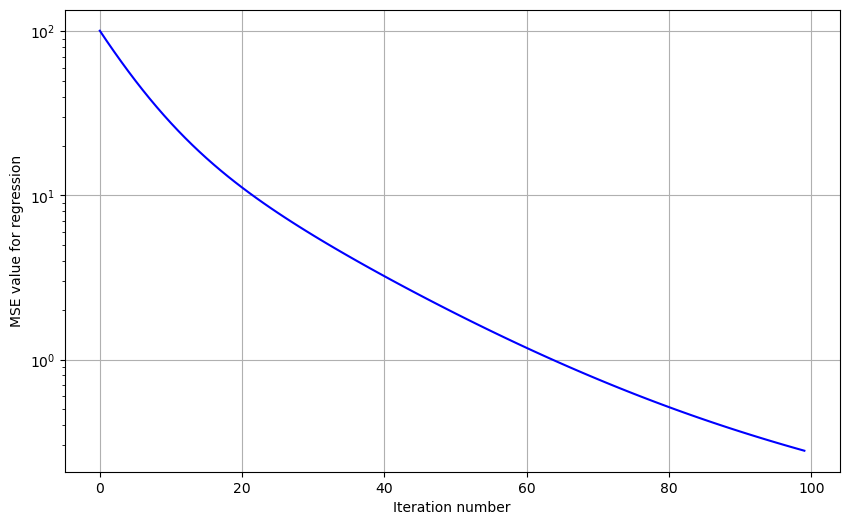

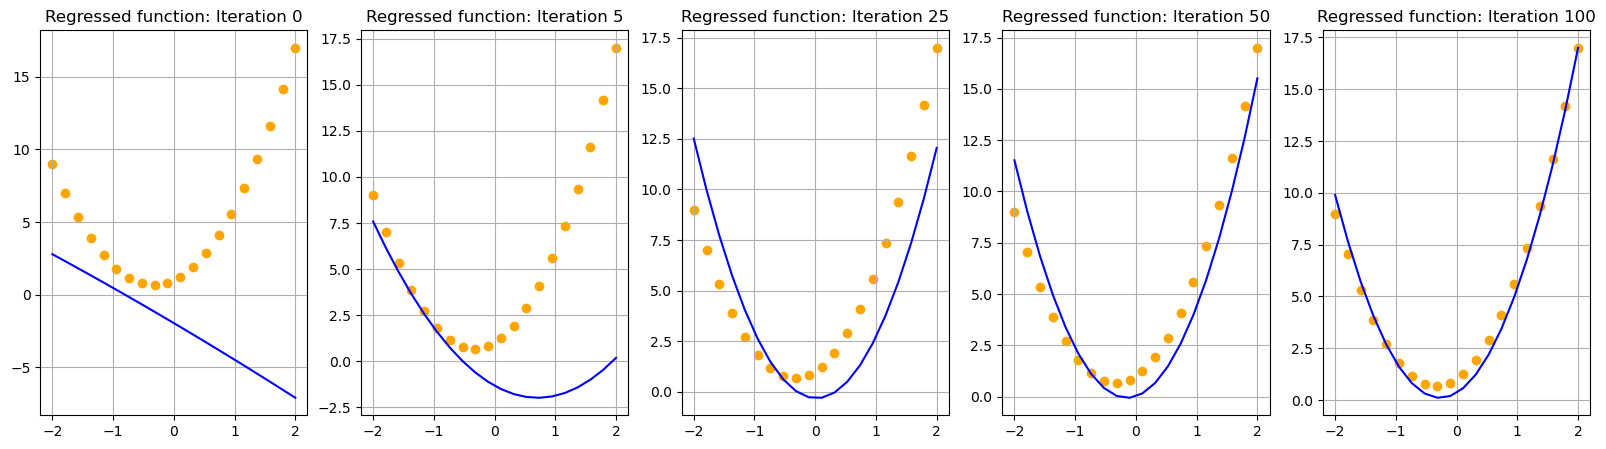

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# values we are trying to regress, pretend we don't know them!
a = 3
b = 2
c = 1

# generate dataset
N = 20 # number of data points
x = np.linspace(-2, 2, N)
y = a*x**2 + b*x + c

# initialize guesses for a, b, and c
a_gd = np.random.randn()
b_gd = np.random.randn()
c_gd = np.random.randn()
print('Initial guesses: a={:.6f}, b={:.6f}, c={:.6f}'.format(a_gd, b_gd, c_gd))

# information for tracking
a_vals = [a_gd]
b_vals = [b_gd]
c_vals = [c_gd]
loss_vals = []

# gradient descent loop
n_iter = 100 # number of iterations
alpha = 1e-2 # step size
for n in range(n_iter):
    # let numpy broadcasting compute all partials across the dataset
    errors = y-(a_gd*x**2 + b_gd*x + c_gd)
    partial_a = np.sum(-2*x**2*errors)/N
    partial_b = np.sum(-2*x*errors)/N
    partial_c = np.sum(-2*errors)/N
    # perform gradient descent update step
    a_gd = a_gd - alpha*partial_a
    b_gd = b_gd - alpha*partial_b
    c_gd = c_gd - alpha*partial_c
    # log information
    loss_vals.append(np.sum(errors**2)/N) # log MSE
    a_vals.append(a_gd)
    b_vals.append(b_gd)
    c_vals.append(c_gd)

# examine solution
print('Final guesses: a={:.6f}, b={:.6f}, c={:.6f}'.format(a_vals[-1], b_vals[-1], c_vals[-1]))

# visualize loss and progression of solution
plt.figure(figsize=(10, 6))
plt.semilogy(loss_vals, color='blue')
plt.grid(True)
plt.xlabel('Iteration number')
plt.ylabel('MSE value for regression')

iter_num = np.array([0, 5, 25, 50, 100]).astype(int)

plt.figure(figsize=(20, 5))
for j, i in enumerate(iter_num):
    plt.subplot(1, 5, j+1)
    curr_fn = a_vals[i]*x**2 + b_vals[i]*x + c_vals[i]
    plt.plot(x, curr_fn, color='blue')
    plt.scatter(x, y, color='orange')
    plt.grid(True)
    plt.title('Regressed function: Iteration {}'.format(i))

## Using PyTorch Autograd

We have briefly explored the PyTorch Autograd engine in previous lectures thus far. Now, we want to utilize it to automatically perform backpropagation for us and make gradient descent much more scalable!

Let's start by showing how the previous example can be converted from Numpy to PyTorch code:

Initial guesses: a=0.953532, b=1.201146, c=0.426644
Final guesses: a=2.952664, b=1.959895, c=1.112451


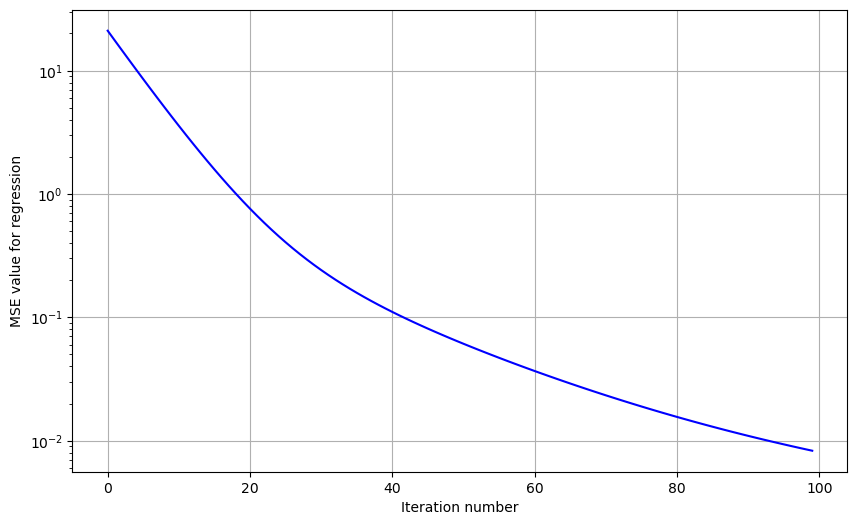

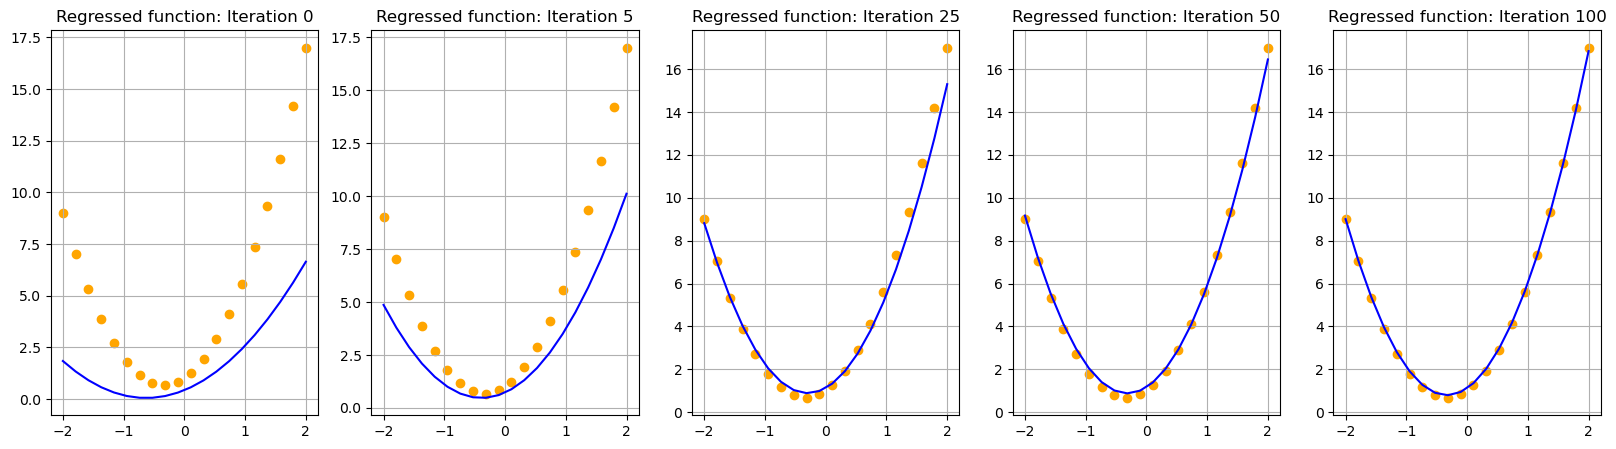

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# values we are trying to regress, pretend we don't know them!
a = 3
b = 2
c = 1

# generate dataset
N = 20 # number of data points
x = torch.linspace(-2, 2, N)
y = a*x**2 + b*x + c

# initialize guesses for a, b, and c
a_gd = torch.randn((), requires_grad=True) # size (1,)
b_gd = torch.randn((), requires_grad=True)
c_gd = torch.randn((), requires_grad=True)
print('Initial guesses: a={:.6f}, b={:.6f}, c={:.6f}'.format(a_gd.data, b_gd.data, c_gd.data))

# information for tracking
a_vals = [a_gd.data.item()]
b_vals = [b_gd.data.item()]
c_vals = [c_gd.data.item()]
loss_vals = []

# gradient descent loop
n_iter = 100 # number of iterations
alpha = 1e-2 # step size
for n in range(n_iter):
    # compute loss function (objective function)
    errors = y-(a_gd*x**2 + b_gd*x + c_gd)
    loss = torch.sum((errors)**2)/N
    # backpropagate gradients
    loss.backward()
    # perform gradient descent update step
    with torch.no_grad():
        # don't want the gradient update step to accumulate further gradients at a, b, and c
        a_gd -= alpha*a_gd.grad
        b_gd -= alpha*b_gd.grad
        c_gd -= alpha*c_gd.grad
        # manually zero out the gradients before next backward pass
        a_gd.grad = None
        b_gd.grad = None
        c_gd.grad = None
        
    # log information
    loss_vals.append(loss.item()) # log MSE
    a_vals.append(a_gd.data.item())
    b_vals.append(b_gd.data.item())
    c_vals.append(c_gd.data.item())

# examine solution
print('Final guesses: a={:.6f}, b={:.6f}, c={:.6f}'.format(a_vals[-1], b_vals[-1], c_vals[-1]))

# visualize loss and progression of solution
plt.figure(figsize=(10, 6))
plt.semilogy(loss_vals, color='blue')
plt.grid(True)
plt.xlabel('Iteration number')
plt.ylabel('MSE value for regression')

iter_num = np.array([0, 5, 25, 50, 100]).astype(int)
plt.figure(figsize=(20, 5))
for j, i in enumerate(iter_num):
    plt.subplot(1, 5, j+1)
    curr_fn = a_vals[i]*x**2 + b_vals[i]*x + c_vals[i]
    plt.plot(x.detach().numpy(), curr_fn.detach().numpy(), color='blue')
    plt.scatter(x.detach().numpy(), y, color='orange')
    plt.grid(True)
    plt.title('Regressed function: Iteration {}'.format(i))

A few notes to the above implementation:

* ``requires_grad=True``: Recall that we set this attribute to True when we would like to access gradients for the given tensor. In this case, we wanted gradients for tensors ``a_gd``, ``b_gd``, and ``c_gd`` since they are our parameters of interest.
* ``.data.item()``: The ``.data`` attribute accesses only the data in the tensor, but still returns a tensor. If we want just the numerical data outside of the tensor data structure, we need to also call the ``.item()`` method.
* ``torch.no_grad()``: The ``torch.no_grad()`` method specifies that no computation within its scope will alter gradients within a computational graph. In our above example, we do not want the gradient descent update step to affect the gradients we already backpropagated. This is also why we used ``-=`` instead of ``a_gd = a_gd - ...`` since this would remove the ``requires_grad`` from each tensor.
* Setting gradients to ``None``: The gradients at each node in the graph remain there until they are cleared. Thus, we need to remove them by setting each to ``None`` before the next backpropagation pass.
* ``detach.numpy()``: The tensor ``x`` belongs to computational graph that require gradients. We must first detach these tensors from the computational graph if we intend to convert them to NumPy arrays for plotting. Alternatively, we could wrap our plotting in a ``torch.no_grad()`` statement.

Some of these above points, e.g. specifying every Tensor that needs gradients, setting gradients to ``None``, and even applying the gradient descent step to every parameters, may seem tedious. And that's okay! In later lectures, we will show how the ``nn.Module`` class and ``torch.optim`` module greatly simplify code like above to only require a few lines instead of around a dozen.

For now, we have successfully used PyTorch and its auto-differentiation engine to perform our first machine learning problem! Let's conclude this lecture with another example.

## Lecture Exercise: Sigmoid Function Regression
Recall from an earlier lecture where we introduced the sigmoid function $\sigma(x)$:
$$
\sigma(x) = \frac{1}{1+e^{-x}}.
$$
We extended sigmoid in one lecture exercise to have a different center point, i.e. where $\sigma(x)=0.5$, and a sharper/smoother transition. Consider this augmented sigmoid function as $\tilde{\sigma}(x)$:
$$
\tilde{\sigma}(x) = \frac{1}{1+\exp{\{-\frac{x-b}{\tau}}\}},
$$
where $b$ and $\tau$ give the center point and shape parameter, respectively. For this exercise, we would will use PyTorch, backpropagation, and gradient descent to automatically determine the $b$ and $\tau$ values of a mystery sigmoid function. We can again use mean squared error to minimize the following objective function over dataset $\mathcal{D}=\{(x_i, y_i)\}$ where each $y_i$ is generated from a mystery sigmoid function $\tilde{\sigma}(x_i)$.
$$
\underset{b, \tau}{\min}~\frac{1}{N}\sum_{i=1}^{N}(y_i-f(x_i;b,\tau))^2
$$

a) Initialize the tensors for $b$ and $\tau$. Print these initial values. **Note**: Make sure that $\tau$ is a positive value! 

b) Complete the below gradient descent loop for updating the parameters with $\alpha=10^{-1}$ for 300 iterations. Print the final value for the parameters.

c) Plot the dataset as a scatter plot and your solution curve as a line plot, i.e. fill in the empty ``f_x`` line of code.

d) Experiment with different step sizes, number of iterations, and different "unknown" values of $b$ and $\tau$.

e) **Bonus**: Can we find good estimates for $b$ and $\tau$ when we draw points for $x\in[0, 1]$ instead of $[-10, 10]$? Or similarly small intervals?

Initial guesses: b_gd=-0.527133, tau_gd=0.604576
Final values: b_gd=-0.134476, tau_gd=1.114500


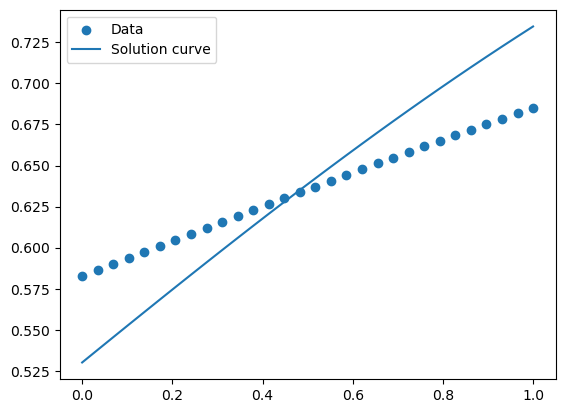

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# "unknown" parameters we are trying to uncover
b = -0.75
tau = 2.25
b_vals= [-torch.randn(1)]
tau_vals = [torch.randn(1)*3]
loss_vals = []
# create dataset
N = 30 # number of datapoints
x = torch.linspace(0, 1, N)
y = 1/(1+torch.exp(-(x-b)/tau))

# part (a) initialize parameters
b_gd = torch.randn((), requires_grad=True)
tau_gd = torch.randn((), requires_grad=True)
print('Initial guesses: b_gd={:.6f}, tau_gd={:.6f}'.format(b_gd.data, tau_gd.data))
# part (b) gradient descent loop
n_iter = 300
alpha = 1e-1
for n in range(n_iter):
    # compute function outputs
    f_x = 1/(1+torch.exp(-(x-b_gd)/tau_gd))
    # calculate loss and initiate backpropagation
    errors= (y-f_x)
    loss= torch.sum(errors**2)/N
    loss.backward()
    # update parameters by gradient descent
    with torch.no_grad():
        # gradient step
        b_gd -= alpha*b_gd.grad
        tau_gd -= alpha*tau_gd.grad
        # set gradients to None
        b_gd.grad = None
        tau_gd.grad = None
    # log information
    loss_vals.append(loss.item())
    b_vals.append(b_gd.data.item())
    tau_vals.append(tau_gd.data.item())
# print final guesses
print('Final values: b_gd={:.6f}, tau_gd={:.6f}'.format(b_gd.data, tau_gd.data))

# part (c) plot the dataset and solution curve
plt.scatter(x, y, label='Data')
plt.plot(x, f_x.detach(), label='Solution curve')
plt.legend()
plt.show()

    